# Social Media Detox Effect Analyzer — Project Plan

**Author:** (Your name)

**Date:** 2025-10-29

---

This notebook is a detailed project plan and a runnable starter for the "Social Media Detox Effect Analyzer." It contains conceptual descriptions, a reproducible synthetic dataset generator, EDA, model sketches, evaluation metrics, visualization examples, and a dashboard prototype outline.

Outline: Setup → Simulate Dataset → Persist → EDA → Preprocessing → Statistical Analysis → Regression → Clustering → Forecasting → Feature Importance → NLP → Evaluation → Dashboard → Recommendations → Persistence & Tests → References


## 1 — Setup: environment, imports, and seeds

This cell documents required packages and sets reproducible seeds. Install packages (if missing) in your environment before running the notebook. Recommended packages: pandas, numpy, scikit-learn, xgboost, tensorflow, prophet (or prophet from fbprophet), nltk/spacy, matplotlib, seaborn, plotly, streamlit, shap, joblib.

We set seeds for numpy and (optionally) TensorFlow/PyTorch for reproducibility. This cell also shows a short note on configuring VS Code to run notebooks and run tests (pytest).

In [8]:
# Cell: Imports and reproducibility
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Optional: set TensorFlow seed if TF is installed
try:
    import tensorflow as tf
    tf.random.set_seed(SEED)
except Exception:
    pass

print('Imports done. Seed =', SEED)

Imports done. Seed = 42


## 2 — Simulate Dataset (synthetic longitudinal users + logs)

This code cell generates a synthetic longitudinal dataset per user for a 30-day window and aggregates per user-date. The simulation encodes simple causal patterns: increasing Days_Without_Social_Media tends to reduce Screen_Time and Stress_Level, and increase Happiness_Score. We include Journal_Text and Journal_Sentiment (simulated). The dataset columns: User_ID, Date, Days_Without_Social_Media, Happiness_Score (0-10), Stress_Level (0-10), Sleep_Hours, Exercise_Minutes, Screen_Time (min), Work_Productivity, Journal_Text, Journal_Sentiment.

In [9]:
# Cell: Synthetic data generation
import numpy as np
import pandas as pd
from datetime import timedelta, date

# Parameters
n_users = 200
days = 30
start_date = pd.to_datetime('2025-09-01')
user_ids = [f'U{str(i).zfill(4)}' for i in range(1, n_users+1)]

rows = []
for uid in user_ids:
    # user-level baseline traits
    base_happiness = np.clip(np.random.normal(6.0, 1.2), 2, 9)
    base_stress = np.clip(np.random.normal(4.0, 1.5), 0, 9)
    base_sleep = np.clip(np.random.normal(7.0, 0.8), 4, 9)
    base_exercise = np.clip(np.random.poisson(30), 0, 120)
    base_productivity = np.clip(np.random.normal(70, 10), 30, 100)
    # simulate a random detox start/behavior
    detox_start = np.random.randint(0, days//2)
    detox_adherence = np.random.beta(2, 5)  # how strongly they adhere

    for d in range(days):
        day = start_date + pd.Timedelta(days=d)
        # if after detox start, increase Days_Without_Social_Media gradually depending on adherence
        if d >= detox_start:
            days_off = int((d - detox_start + 1) * detox_adherence)
        else:
            days_off = 0
        # Screen time decreases with days_off but has noise
        base_screen = np.clip(np.random.normal(180, 40), 60, 600)  # minutes
        screen_time = np.clip(base_screen - 8 * days_off + np.random.normal(0, 15), 15, 720)
        # happiness increases slightly with days_off, decreases with screen_time and stress
        happiness = np.clip(base_happiness + 0.1*days_off - 0.003*(screen_time-120) + np.random.normal(0,0.6), 0, 10)
        # stress decreases with days_off and with better sleep/exercise
        sleep = np.clip(base_sleep + 0.02*days_off + np.random.normal(0,0.5), 3, 10)
        exercise = np.clip(base_exercise + np.random.normal(0,10) + 0.5*days_off, 0, 300)
        stress = np.clip(base_stress - 0.08*days_off + 0.002*(screen_time-120) - 0.05*(sleep-7) + np.random.normal(0,0.7), 0, 10)
        productivity = np.clip(base_productivity + 0.2*days_off - 0.01*(screen_time-120) + np.random.normal(0,5), 0, 100)
        # journal sentiment: approximate from happiness-stress balance
        journal_sentiment = np.tanh((happiness - stress)/4 + np.random.normal(0,0.2))  # -1..1
        # journal text (short synthetic phrases)
        if journal_sentiment > 0.4:
            journal_text = "Feeling good, focusing on real life, less scrolling."
        elif journal_sentiment > 0:
            journal_text = "Not bad today — less doomscrolling, more sleep."
        elif journal_sentiment > -0.4:
            journal_text = "A bit tense, checking my feeds sometimes."
        else:
            journal_text = "Stressful day, couldn't stop checking social apps."

        rows.append({
            'User_ID': uid,
            'Date': day,
            'Days_Without_Social_Media': days_off,
            'Happiness_Score': round(float(happiness), 2),
            'Stress_Level': round(float(stress), 2),
            'Sleep_Hours': round(float(sleep), 2),
            'Exercise_Minutes': float(exercise),
            'Screen_Time': float(screen_time),
            'Work_Productivity': round(float(productivity), 2),
            'Journal_Text': journal_text,
            'Journal_Sentiment': round(float(journal_sentiment), 3)
        })

# assemble DataFrame
df = pd.DataFrame(rows)

# quick sanity checks
print('rows, users, days:', df.shape, df['User_ID'].nunique(), df['Date'].nunique())
df.head()


rows, users, days: (6000, 11) 200 30


,User_ID,Date,Days_Without_Social_Media,Happiness_Score,Stress_Level,Sleep_Hours,Exercise_Minutes,Screen_Time,Work_Productivity,Journal_Text,Journal_Sentiment
0,U0001,2025-09-01,0,6.43,3.82,7.30,17.681826,180.800525,85.73,"Feeling good, focusing on real life, less scro...",0.461
1,U0001,2025-09-02,0,7.08,5.24,7.47,17.748771,185.178801,74.44,"Feeling good, focusing on real life, less scro...",0.594
2,U0001,2025-09-03,0,7.05,3.10,7.70,19.135270,194.651239,87.31,"Feeling good, focusing on real life, less scro...",0.690
3,U0001,2025-09-04,0,6.32,4.60,7.55,21.237143,119.585678,88.73,"Not bad today — less doomscrolling, more sleep.",0.375
4,U0001,2025-09-05,0,6.94,4.93,8.85,25.634860,161.541923,87.12,"Feeling good, focusing on real life, less scro...",0.477


Aggregated users: (200, 9)


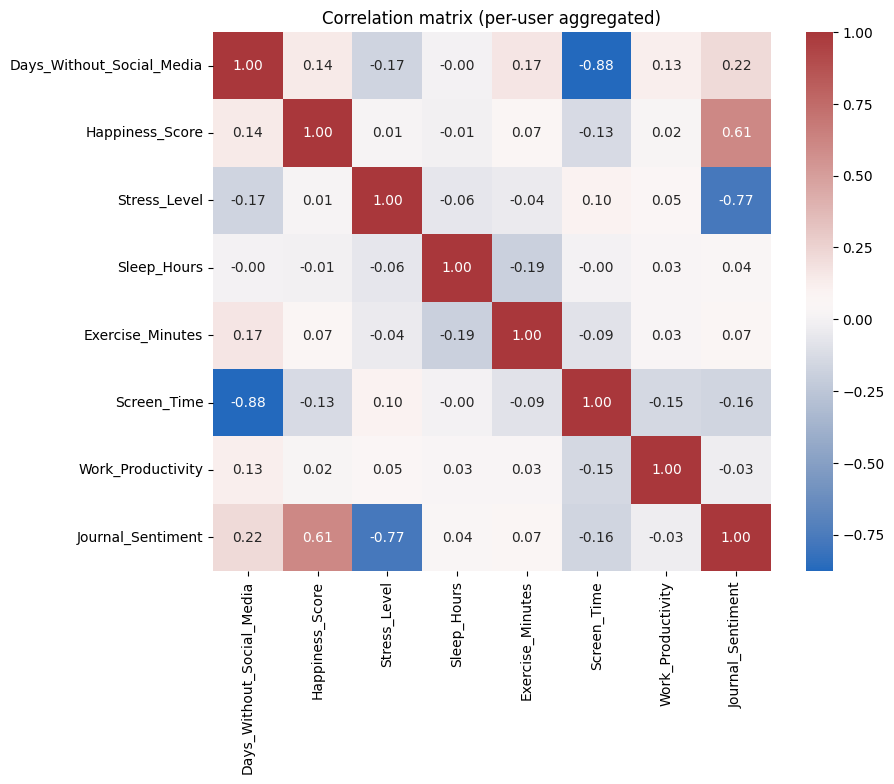

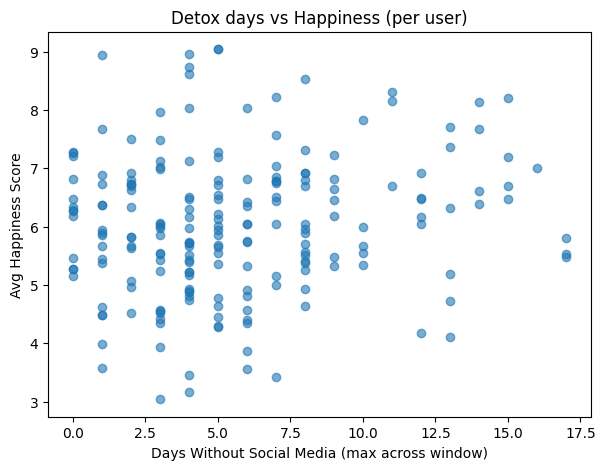

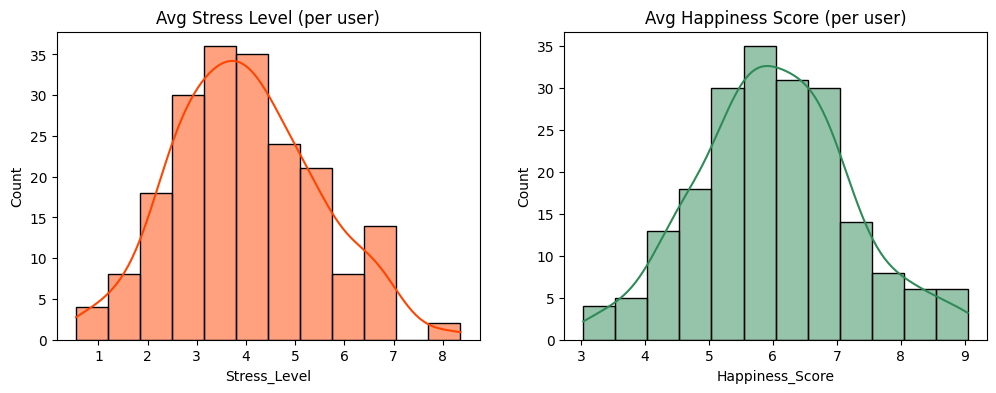

In [10]:
# Cell: Basic EDA — correlations and plots
import matplotlib.pyplot as plt
import seaborn as sns

# Aggregate per user for clustering/summary EDA
agg = df.groupby('User_ID').agg({
    'Days_Without_Social_Media': 'max',
    'Happiness_Score': 'mean',
    'Stress_Level': 'mean',
    'Sleep_Hours': 'mean',
    'Exercise_Minutes': 'mean',
    'Screen_Time': 'mean',
    'Work_Productivity': 'mean',
    'Journal_Sentiment': 'mean'
}).reset_index()

print('Aggregated users:', agg.shape)

# Correlation heatmap (aggregated)
plt.figure(figsize=(9,7))
cm = agg.select_dtypes(include=[float, int]).corr()
sns.heatmap(cm, annot=True, fmt='.2f', cmap='vlag')
plt.title('Correlation matrix (per-user aggregated)')
plt.show()

# Scatter: Days_Without_Social_Media vs Happiness
plt.figure(figsize=(7,5))
plt.scatter(agg['Days_Without_Social_Media'], agg['Happiness_Score'], alpha=0.6)
plt.xlabel('Days Without Social Media (max across window)')
plt.ylabel('Avg Happiness Score')
plt.title('Detox days vs Happiness (per user)')
plt.show()

# Distribution of Stress and Happiness
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(agg['Stress_Level'], kde=True, color='orangered')
plt.title('Avg Stress Level (per user)')
plt.subplot(1,2,2)
sns.histplot(agg['Happiness_Score'], kde=True, color='seagreen')
plt.title('Avg Happiness Score (per user)')
plt.show()


## Prompt Templates included in this project

I added a set of AI prompt templates to help automate and accelerate development. They are saved in the `prompts/` folder. Use them by copying the content into ChatGPT/Claude/Gemini.

Files created:
- `prompts/ai_assistant_prompt.txt` — Full project implementation guide (6 phases)
- `prompts/prompt_python_implementation.txt` — Quick runnable Python code
- `prompts/prompt_jupyter_notebook.txt` — Notebook-structured prompt
- `prompts/prompt_specific_analysis.txt` — Focused analysis prompts
- `prompts/prompt_research_paper_format.txt` — Paper-style methods/results
- `prompts/prompt_dashboard_app.txt` — Streamlit dashboard builder
- `prompts/prompt_step_by_step_beginner.txt` — Beginner tutorial
- `prompts/PROMPT_GUIDE.txt` — Master guide for which prompt to use

Next cell demonstrates how to read and preview these files programmatically.

In [11]:
# Cell: programmatically list and preview prompt files
from pathlib import Path
prompts_dir = Path('prompts')
files = sorted(prompts_dir.glob('*.txt'))
print('Found', len(files), 'prompt files in', prompts_dir.resolve())
for f in files:
    print('\n---', f.name, '---')
    with open(f, 'r', encoding='utf-8') as fh:
        lines = fh.read().splitlines()
        preview = '\n'.join(lines[:12])
        print(preview)
        if len(lines) > 12:
            print('... (preview truncated)')


Found 7 prompt files in C:\Users\RANJITH S\Documents\project\dse\prompts

--- ai_assistant_prompt.txt ---
# AI Assistant Prompt — Comprehensive Full Project Prompt

Goal: Implement the Social Media Detox Effect Analyzer end-to-end. Follow 6 phases and produce runnable code, tests, and a Streamlit dashboard.

Phases:
1. Data Generation & Preprocessing
   - Generate synthetic longitudinal user-level and session-level data with realistic correlations.
   - Validate data types and produce CSV/Parquet.
   - Create preprocessing pipeline: imputers, scalers, feature engineering (rolling windows, deltas, buckets).

2. Exploratory Data Analysis
   - Produce descriptive stats, histograms and boxplots, correlation heatmap, and per-user time series.
... (preview truncated)

--- prompt_dashboard_app.txt ---
# Dashboard App Prompt (Streamlit)

Build a Streamlit app with the following features:
- Multi-tab layout: Overview, Correlation, Regression, Clustering, Prediction, Personal Insights.
- CSV upl

## 3 — Load external dataset (if available) & persist

This cell attempts to load the user-provided dataset `data/Mental_Health_and_Social_Media_Balance_Dataset.csv` if it exists in the workspace. If not found, the notebook will continue using the simulated dataset created above. The code also saves a canonical copy of the active DataFrame to `data/active_dataset.parquet` for fast reloads.

Run this cell after you've copied the CSV into `c:\Users\RANJITH S\Documents\project\dse\data` (see earlier PowerShell snippet).

In [12]:
# Cell: Try to load user CSV (if copied into workspace) otherwise use synthetic `df`
from pathlib import Path
import warnings

data_path = Path('data') / 'Mental_Health_and_Social_Media_Balance_Dataset.csv'
parquet_path = Path('data') / 'active_dataset.parquet'

if data_path.exists():
    print('Found external dataset at', data_path.resolve())
    try:
        user_df = pd.read_csv(data_path)
        print('Loaded CSV: rows, cols =', user_df.shape)
        display(user_df.head())
        df = user_df.copy()
    except Exception as e:
        warnings.warn(f'Failed to read CSV: {e} — falling back to synthetic df')
        # df is already defined (synthetic)
else:
    print('No external CSV found at', data_path.resolve())
    if parquet_path.exists():
        try:
            df = pd.read_parquet(parquet_path)
            print('Loaded cached parquet dataset:', parquet_path)
        except Exception:
            print('Could not read parquet; using synthetic dataset (df)')
    else:
        print('Using synthetic dataset created earlier (df)')

# Persist a canonical copy for faster reloads
try:
    Path('data').mkdir(parents=True, exist_ok=True)
    df.to_parquet(parquet_path, index=False)
    print('Saved canonical dataset to', parquet_path)
except Exception as e:
    warnings.warn(f'Failed to persist dataset: {e}')

# Quick overview
print('\nDataFrame shape:', df.shape)
print('\nColumn types:')
print(df.dtypes)

# Basic null-check
print('\nMissing values per column:')
print(df.isna().sum())


No external CSV found at C:\Users\RANJITH S\Documents\project\dse\data\Mental_Health_and_Social_Media_Balance_Dataset.csv
Using synthetic dataset created earlier (df)
Saved canonical dataset to data\active_dataset.parquet

DataFrame shape: (6000, 11)

Column types:
User_ID                              object
Date                         datetime64[ns]
Days_Without_Social_Media             int64
Happiness_Score                     float64
Stress_Level                        float64
Sleep_Hours                         float64
Exercise_Minutes                    float64
Screen_Time                         float64
Work_Productivity                   float64
Journal_Text                         object
Journal_Sentiment                   float64
dtype: object

Missing values per column:
User_ID                      0
Date                         0
Days_Without_Social_Media    0
Happiness_Score              0
Stress_Level                 0
Sleep_Hours                  0
Exercise_Minutes      

## 4 — Preprocessing & Feature Engineering

Steps implemented here:
- Basic cleaning (type conversion, missing value handling)
- Feature engineering: rolling 7-day mean for Happiness and Stress, delta Screen_Time, Days_Without_Social_Media bucket, sleep_quality index, weekday/weekend flags
- Build a sklearn-compatible preprocessing pipeline and functions for reuse

This cell creates the pipeline and returns a feature matrix X and targets y for downstream models.

In [13]:
# Cell: Preprocessing & feature engineering functions
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Ensure Date is datetime if present
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Example feature engineering: per-user rolling mean & deltas
if 'User_ID' in df.columns and 'Date' in df.columns:
    df = df.sort_values(['User_ID', 'Date'])
    df['Happiness_7d'] = df.groupby('User_ID')['Happiness_Score'].transform(lambda x: x.rolling(7, min_periods=1).mean())
    df['Stress_7d'] = df.groupby('User_ID')['Stress_Level'].transform(lambda x: x.rolling(7, min_periods=1).mean())
    df['Screen_Time_delta'] = df.groupby('User_ID')['Screen_Time'].diff().fillna(0)
    df['Days_Without_bucket'] = pd.cut(df['Days_Without_Social_Media'], bins=[-1,0,3,7,14,365], labels=['0','1-3','4-7','8-14','15+'])
    df['Sleep_Quality'] = (df['Sleep_Hours'] - 7).clip(-3,3)  # simple proxy
    df['is_weekend'] = df['Date'].dt.weekday >= 5
else:
    # For user-agnostic (if CSV doesn't have these columns), create fallbacks
    for c in ['Happiness_7d','Stress_7d','Screen_Time_delta','Days_Without_bucket','Sleep_Quality','is_weekend']:
        if c not in df.columns:
            df[c] = 0

# Select features for modeling
feature_cols = [
    'Days_Without_Social_Media', 'Screen_Time', 'Sleep_Hours', 'Exercise_Minutes',
    'Work_Productivity', 'Happiness_7d', 'Stress_7d', 'Screen_Time_delta', 'Sleep_Quality'
]

# Add indicator columns if present
for c in feature_cols[:]:
    if c not in df.columns:
        feature_cols.remove(c)

# Targets - ask user later; build both by default if available
targets = []
if 'Happiness_Score' in df.columns:
    targets.append('Happiness_Score')
if 'Stress_Level' in df.columns:
    targets.append('Stress_Level')

print('Feature columns used:', feature_cols)
print('Targets available:', targets)

# Build a preprocessing transformer
numeric_features = [c for c in feature_cols if df[c].dtype.kind in 'biufc']
cat_features = [c for c in feature_cols if df[c].dtype == 'O' or str(df[c].dtype).startswith('category')]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', cat_transformer, cat_features)
    ]
)

# Helper to build X, y for chosen target
def build_X_y(df_in, target):
    X = df_in[feature_cols].copy()
    y = df_in[target].copy()
    return X, y

print('Preprocessing setup complete.')


Feature columns used: ['Days_Without_Social_Media', 'Screen_Time', 'Sleep_Hours', 'Exercise_Minutes', 'Work_Productivity', 'Happiness_7d', 'Stress_7d', 'Screen_Time_delta', 'Sleep_Quality']
Targets available: ['Happiness_Score', 'Stress_Level']
Preprocessing setup complete.


## 5 — Baseline Statistical Analysis & Hypothesis Tests

This section computes Pearson and Spearman correlations between Days_Without_Social_Media and Happiness/Stress (if available) and runs paired pre/post comparisons for users who have clear detox windows. It will also compute effect sizes and p-values.

In [14]:
# Cell: Correlations and simple hypothesis tests
from scipy.stats import pearsonr, spearmanr, ttest_rel, wilcoxon

results = {}
if 'Days_Without_Social_Media' in df.columns:
    for target in ['Happiness_Score','Stress_Level']:
        if target in df.columns:
            x = df['Days_Without_Social_Media'].values
            y = df[target].values
            # drop nans
            mask = ~pd.isna(x) & ~pd.isna(y)
            if mask.sum() < 10:
                print(f'Not enough data to compute correlations for {target}')
                continue
            pr, ppr = pearsonr(x[mask], y[mask])
            sr, psr = spearmanr(x[mask], y[mask])
            results[target] = {'pearson_r': pr, 'pearson_p': ppr, 'spearman_r': sr, 'spearman_p': psr}

print('Correlation results:')
for k,v in results.items():
    print(k, v)

# Paired pre/post test: naive approach if we can detect a detox start per user (Days_Without_Social_Media increases)
if 'User_ID' in df.columns and 'Date' in df.columns:
    paired_summary = []
    for uid, g in df.groupby('User_ID'):
        # require at least 14 days of data
        if len(g) < 14:
            continue
        # define pre period = first 7 days, post period = last 7 days
        g_sorted = g.sort_values('Date')
        pre = g_sorted.iloc[:7]
        post = g_sorted.iloc[-7:]
        if 'Happiness_Score' in df.columns:
            stat, p = ttest_rel(pre['Happiness_Score'], post['Happiness_Score'])
            paired_summary.append({'User_ID': uid, 'Happiness_t_stat': stat, 'Happiness_p': p})
    paired_df = pd.DataFrame(paired_summary)
    print('\nPaired test summary (first 10 users):')
    display(paired_df.head(10))

print('\nBaseline stats complete.')


Correlation results:
Happiness_Score {'pearson_r': 0.23186090115239646, 'pearson_p': 4.7320882921371234e-74, 'spearman_r': 0.19065105581867187, 'spearman_p': 3.2194280003968285e-50}
Stress_Level {'pearson_r': -0.1883591022975289, 'pearson_p': 4.858847123761279e-49, 'spearman_r': -0.1589153050994754, 'spearman_p': 3.1217434048562954e-35}

Paired test summary (first 10 users):


,User_ID,Happiness_t_stat,Happiness_p
0,U0001,1.603746,0.159891
1,U0002,-0.367725,0.725702
2,U0003,-1.367078,0.220603
3,U0004,0.392959,0.707931
4,U0005,-2.725824,0.034376
5,U0006,-1.458807,0.194900
6,U0007,-1.577365,0.165786
7,U0008,-1.577295,0.165802
8,U0009,-3.842992,0.008529
9,U0010,-4.479891,0.004193



Baseline stats complete.


## 6 — Regression Models & Hybrid Stacking Ensemble

This section trains baseline models (Linear Regression, Polynomial) and a hybrid stacking regressor for each continuous target. The stacking ensemble uses a gradient boosting tree (XGBoost or sklearn's GradientBoosting), RandomForest, and ElasticNet as base learners, with a Ridge meta-learner. Results include cross-validated RMSE and R^2. The code is robust to missing packages (falls back if XGBoost isn't installed).

In [15]:
# Cell: Regression pipelines and stacking training
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# try xgboost if present
try:
    import xgboost as xgb
    XGBReg = xgb.XGBRegressor
    print('XGBoost available')
except Exception:
    XGBReg = GradientBoostingRegressor
    print('XGBoost not available, using GradientBoostingRegressor instead')

cv = KFold(n_splits=5, shuffle=True, random_state=SEED)

def evaluate_model(model, X, y):
    # compute CV RMSE and R2
    neg_mse = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
    r2 = cross_val_score(model, X, y, scoring='r2', cv=cv, n_jobs=-1)
    rmse = np.sqrt(-neg_mse)
    return {'rmse_mean': rmse.mean(), 'rmse_std': rmse.std(), 'r2_mean': r2.mean(), 'r2_std': r2.std()}

trained_models = {}

for target in targets:
    print('\nTraining for target:', target)
    X, y = build_X_y(df, target)
    # Drop rows with NaN in y or X
    mask = ~y.isna()
    Xr = X[mask]
    yr = y[mask]
    # Baseline linear
    lin = make_pipeline(preprocessor, LinearRegression())
    lin_res = evaluate_model(lin, Xr, yr)
    print('Linear Regression CV RMSE:', lin_res['rmse_mean'])

    # Polynomial degree 2
    poly = make_pipeline(preprocessor, PolynomialFeatures(degree=2, include_bias=False), LinearRegression())
    try:
        poly_res = evaluate_model(poly, Xr, yr)
        print('Polynomial(2) CV RMSE:', poly_res['rmse_mean'])
    except Exception as e:
        print('Polynomial pipeline failed:', e)

    # Stacking ensemble: XGB/GB, RandomForest, ElasticNet
    estimators = [
        ('rf', RandomForestRegressor(n_estimators=100, random_state=SEED)),
        ('gb', XGBReg(n_estimators=100, random_state=SEED)),
        ('en', make_pipeline(StandardScaler(), ElasticNet(random_state=SEED)))
    ]
    stack = StackingRegressor(estimators=estimators, final_estimator=Ridge(), n_jobs=-1, passthrough=False)
    stack_pipe = make_pipeline(preprocessor, stack)
    stack_res = evaluate_model(stack_pipe, Xr, yr)
    print('Stacking CV RMSE:', stack_res['rmse_mean'], 'R2:', stack_res['r2_mean'])

    # Fit on full data and save model object for deployment
    try:
        stack_pipe.fit(Xr, yr)
        trained_models[target] = stack_pipe
        print('Trained and saved stacking model for', target)
    except Exception as e:
        print('Failed to fit stacking model on full data:', e)

print('\nRegression training complete. Trained models keys:', list(trained_models.keys()))


XGBoost not available, using GradientBoostingRegressor instead

Training for target: Happiness_Score
Linear Regression CV RMSE: 0.5388832277148137
Polynomial(2) CV RMSE: 0.7479236016395973
Stacking CV RMSE: 0.5442647833477541 R2: 0.8402259722380869
Trained and saved stacking model for Happiness_Score

Training for target: Stress_Level
Linear Regression CV RMSE: 0.6329860686674988
Polynomial(2) CV RMSE: 1.3164631269644755
Stacking CV RMSE: 0.6367308619660709 R2: 0.8474458999475395
Trained and saved stacking model for Stress_Level

Regression training complete. Trained models keys: ['Happiness_Score', 'Stress_Level']
